<a href="https://colab.research.google.com/github/TonyaAlekhina/Big-Data-Analysis/blob/main/Project_Network_Analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ социального графа

Загрузим необходимые библиотеки для работы с графами и сетями

In [ ]:
import numpy as np
import pandas as pd 
import math
import networkx as nx
import community
from networkx.algorithms import bipartite, community

from operator import itemgetter

import matplotlib.pyplot as plt


## Пример 1

Создадим произвольный граф `G` перечислением его вершин `{A, B, C, D, E, F}`, дугами `{AB, BC, BD, EB, EA, FB}`, силой связи между вершинами и характером связи `{'friend', 'family', 'enemy'}`. Для этого инициируем граф и будем добавлять в него дуги методом  `add_edge`

In [ ]:
G = nx.Graph()
G.add_edge('A', 'B', weight = 14, relation = 'friend')
G.add_edge('A', 'C', weight = 7, relation = 'friend')
G.add_edge('B', 'D', weight = 9, relation = 'family')
G.add_edge('E', 'B', weight = 8, relation = 'friend')
G.add_edge('E', 'A', weight = 2, relation = 'enemy')
G.add_edge('F', 'B', weight = 15, relation = 'family')


Придадим ролевой статус вершинам `A`, `B`, `C`. Укажем, например, для них вид деятельности `'Trader'`, `'Analyst'`, `'Manager'`. Используем метод `add_node`

In [ ]:
G.add_node('A', role = 'Trader')
G.add_node('B', role = 'Analyst')
G.add_node('C', role = 'Manager')

Изобразим полученный граф. Используем метод `draw_networkx`

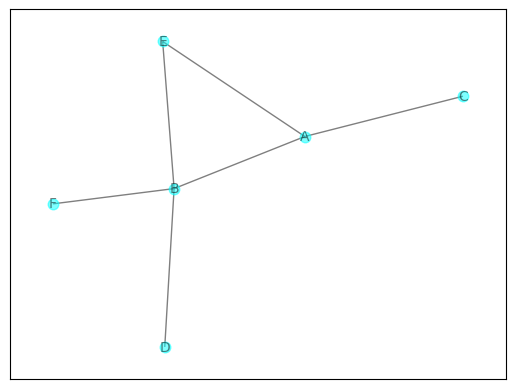

In [ ]:
nx.draw_networkx(G, with_labels = True, node_color = 'cyan', edge_color = 'black', node_size = 58, alpha = 0.5, font_size = 10)

# Пример 2

Построим двудольный граф. Для построения каждого компонента двудольного графа используйте параметр `bipartite`

In [ ]:
B = nx.Graph()
B.add_nodes_from(['A', 'B', 'C', 'D', 'E'], bipartite = 0) # точки
B.add_nodes_from(['F', 'G', 'H', 'I'], bipartite = 1) # дуги
B.add_edges_from([('A', 'F'), ('B', 'F'), ('C', 'F'), ('C', 'H'), ('D', 'I'), ('E', 'F'), ('E', 'G')])

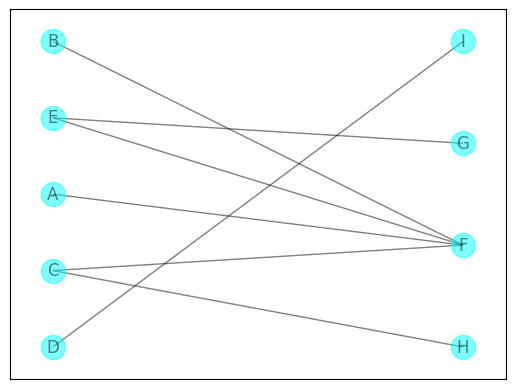

In [ ]:
# Изобразим построенный граф 
nx.draw_networkx(B, pos = nx.drawing.layout.bipartite_layout(B, ['A', 'B', 'C', 'D', 'E']), node_color = 'cyan', alpha = 0.5)

## Пример 3

Проанализируем граф социальных связей квакеров (Религиозное общество Друзей)

Загрузим файлы `quakers_nodelist.csv` и `quakers_edgelist.csv`, содержащие вершины социального графа и их атрибуты и связи между ними в переменные `nodes` и `edges` соответственно.

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
nodes = pd.read_csv('/content/drive/My Drive/Big Data/quakers_nodelist.csv')
edges = pd.read_csv('/content/drive/My Drive/Big Data/quakers_edgelist.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Первые 5 строк датасета вершин
nodes.head()

,Name,Historical Significance,Gender,Birthdate,Deathdate,ID
0,Joseph Wyeth,religious writer,male,1663,1731,10013191
1,Alexander Skene of Newtyle,local politician and author,male,1621,1694,10011149
2,James Logan,colonial official and scholar,male,1674,1751,10007567
3,Dorcas Erbery,Quaker preacher,female,1656,1659,10003983
4,Lilias Skene,Quaker preacher and poet,male,1626,1697,10011152


In [ ]:
# Размерность датасета вершин
nodes.shape

(119, 6)

In [ ]:
# Первые 5 строк датасета связей
edges.head()

,Source,Target
0,George Keith,Robert Barclay
1,George Keith,Benjamin Furly
2,George Keith,Anne Conway Viscountess Conway and Killultagh
3,George Keith,Franciscus Mercurius van Helmont
4,George Keith,William Penn


In [ ]:
# Размерность датасета связей
edges.shape

(174, 2)

In [ ]:
# Объединим данные из датасетов в один граф, где вершинами будут имена квакеров. Для этого используем from_pandas_edgelist
G = nx.Graph()
G = nx.from_pandas_edgelist(edges, source = 'Source', target = 'Target')

Добавим атрибуты вершин графа. Данные об историческом значении, пол, год рождения и год смерти будем считать атрибутами вершин.

Для добавления атрибутов вершинам графа используем метод `set_node_attributes`. Для этого необхлдимо создать словарь или список всех атрибутов.

In [ ]:
attr_dict = nodes.set_index('Name')['Historical Significance'].to_dict()
nx.set_node_attributes(G, attr_dict, 'hist_sign')
attr_dict = nodes.set_index('Name')['Gender'].to_dict()
nx.set_node_attributes(G, attr_dict, 'gender')
attr_dict = nodes.set_index('Name')['Birthdate'].to_dict()
nx.set_node_attributes(G, attr_dict, 'birth_year')
attr_dict = nodes.set_index('Name')['Deathdate'].to_dict()
nx.set_node_attributes(G, attr_dict, 'death_date')

In [ ]:
# Проверим, что из себя представляет полученный граф. Информацию о числе вершин и связей можно получить методом info()
print('Вершины', len(G.nodes))
print('Ребра', len(G.edges))

Вершины 119
Ребра 174


In [ ]:
# Список вершин
G.nodes

NodeView(('George Keith', 'Robert Barclay', 'Benjamin Furly', 'Anne Conway Viscountess Conway and Killultagh', 'Franciscus Mercurius van Helmont', 'William Penn', 'George Fox', 'George Whitehead', 'William Bradford', 'James Parnel', 'Stephen Crisp', 'Peter Collinson', 'John Bartram', 'James Logan', 'Joseph Wyeth', 'Thomas Ellwood', 'Alexander Skene of Newtyle', 'Lilias Skene', 'Dorcas Erbery', 'James Nayler', 'William Mucklow', 'William Dewsbury', 'Edward Burrough', 'John Crook', 'John Audland', 'John Camm', 'Francis Howgill', 'Edward Pyott', 'Charles Marshall', 'Anne Camm', 'Martha Simmonds', 'Richard Farnworth', 'William Crouch', 'Tace Sowle', 'John Bellers', 'Fettiplace Bellers', 'William Rogers', 'Hannah Stranger', 'Isabel Yeamans', 'George Fox the younger', 'Margaret Fell', 'Ellis Hookes', 'William Mead', 'Elizabeth Hooten', 'Thomas Salthouse', 'John Wilkinson', 'William Coddington', 'John Stubbs', 'John Perrot', 'Leonard Fell', 'William Caton', 'Samuel Fisher', 'John Burnyeat', '

In [ ]:
# Обратимся к атрибутам вершин. Выведем на экран список всех квакеров и год их рождения
for name in G.nodes():
  print(name, G.nodes[name]['birth_year'])

George Keith 1638
Robert Barclay 1648
Benjamin Furly 1636
Anne Conway Viscountess Conway and Killultagh 1631
Franciscus Mercurius van Helmont 1614
William Penn 1644
George Fox 1624
George Whitehead 1637
William Bradford 1663
James Parnel 1636
Stephen Crisp 1628
Peter Collinson 1694
John Bartram 1699
James Logan 1674
Joseph Wyeth 1663
Thomas Ellwood 1639
Alexander Skene of Newtyle 1621
Lilias Skene 1626
Dorcas Erbery 1656
James Nayler 1618
William Mucklow 1630
William Dewsbury 1621
Edward Burrough 1633
John Crook 1616
John Audland 1630
John Camm 1605
Francis Howgill 1618
Edward Pyott 1560
Charles Marshall 1637
Anne Camm 1627
Martha Simmonds 1624
Richard Farnworth 1630
William Crouch 1628
Tace Sowle 1666
John Bellers 1654
Fettiplace Bellers 1687
William Rogers 1601
Hannah Stranger 1656
Isabel Yeamans 1637
George Fox the younger 1551
Margaret Fell 1614
Ellis Hookes 1635
William Mead 1627
Elizabeth Hooten 1562
Thomas Salthouse 1630
John Wilkinson 1652
William Coddington 1601
John Stubbs 16

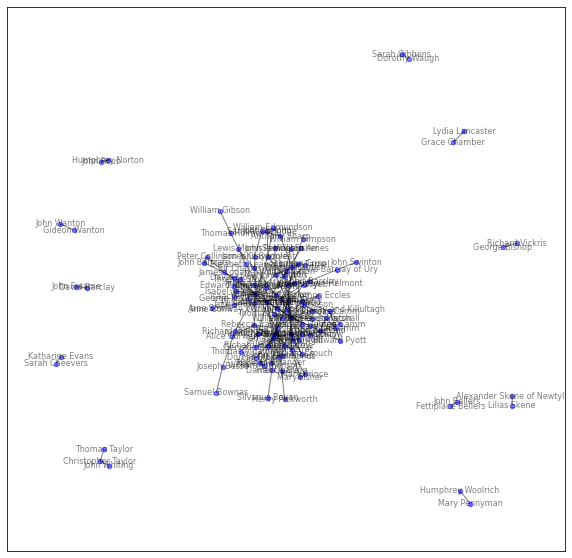

In [ ]:
# Изобразим построенный граф связей
plt.figure(figsize = (10, 10))
nx.draw_networkx(G, with_labels = True, node_color = 'blue', edge_color = 'black', node_size = 20, font_size = 8, alpha = 0.5)

Видим, что граф не является связным. Проверим это методом `is_connected`




In [ ]:
nx.is_connected(G)

False

Граф не является связным. Поэтому определим все компоненты связности методом `connected_components` и вычислим диаметр самой большой компоненты методом `diameter`

In [ ]:
# Число компонент графа определим методом number_connected_components
nx.number_connected_components(G)

12

In [ ]:
# Определим диаметр наибольшей связной компоненты графа 
components = nx.connected_components(G)
largest_component = max(components, key = len)
largest_component
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print('Диаметр наибольшей связной компоненты графа:', diameter)

Диаметр наибольшей связной компоненты графа: 8


Таким образом, наиболее удаленные друг от друга вершины графа находятся на расстоянии 8 дуг. То есть все квакеры связаны друг с другом не больше, чем через 8 рукопожатий.

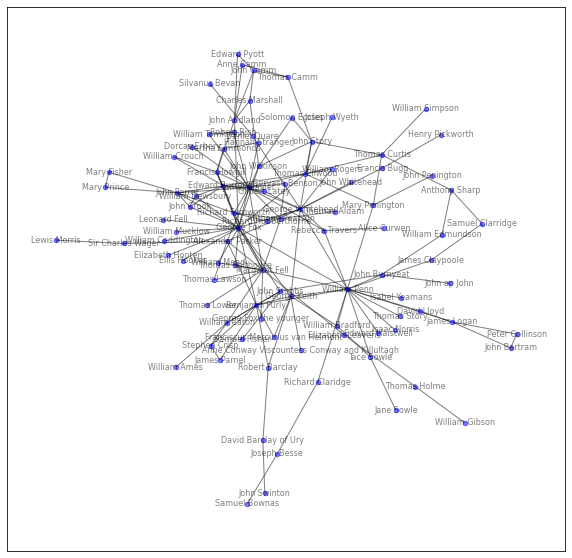

In [ ]:
# Изобразим граф наибольшей компоненты связности 
plt.figure(figsize = (10, 10))
nx.draw_networkx(subgraph, with_labels = True, node_color = 'blue', edge_color = 'black', node_size = 20, font_size = 8, alpha = 0.5)

In [ ]:
# Определим число вершин в наибольшей компоненте связности
subgraph.number_of_nodes()

96

### Сетевые метрики

### Плотность

Определим плотность сети методом `density`.

Плотность – это отношение числа имеющихся рёбер графа к максимально возможному количеству рёбер данного графа. Плотность – распространённая метрика, она используется в первую очередь при сравнении графов одного размера или при сравнении графа с самим собой во времени

In [ ]:
density = nx.density(G)
print('Плотность сети', density)

Плотность сети 0.02478279447372169


Найдем кратчайшие пути между некоторыми квакерами. Например, между `Margaret Fell` и `George Whitehead`.

Используем метод `shortest_path`

In [ ]:
short_path = nx.shortest_path(G, source = 'Margaret Fell', target = 'George Whitehead')
print('Кратчайший путь между Margaret Fell и George Whitehead равен', short_path)

Кратчайший путь между Margaret Fell и George Whitehead равен ['Margaret Fell', 'George Fox', 'George Whitehead']


То есть `Margaret Fell` и `George Whitehead` имеют общего знакомого, через которых они связаны.

In [ ]:
# Длина кратчайшего пути
len(short_path)

3

Возможно, найденный путь между `Margaret Fell` и `George Whitehead` через `George Fox` не является единственным. Для определния всех кратчайших путей используем метод `all_shortest_paths`. Выведем на экран все кратчайшие пути между `Margaret Fell` и `George Whitehead`

In [ ]:
all_short_path = nx.shortest_paths.all_shortest_paths(G, source = 'Margaret Fell', target = 'George Whitehead')
for x in all_short_path:
  print(x)

['Margaret Fell', 'George Fox', 'George Whitehead']
['Margaret Fell', 'James Nayler', 'George Whitehead']
['Margaret Fell', 'William Penn', 'George Whitehead']
['Margaret Fell', 'Alexander Parker', 'George Whitehead']


Определим степени вершин графа методом `degree` и добавим эти значения в атрибуты вершин

In [ ]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [ ]:
for name in G.nodes():
  print(name, G.nodes[name]['degree'])

George Keith 8
Robert Barclay 3
Benjamin Furly 10
Anne Conway Viscountess Conway and Killultagh 1
Franciscus Mercurius van Helmont 2
William Penn 18
George Fox 22
George Whitehead 13
William Bradford 3
James Parnel 2
Stephen Crisp 3
Peter Collinson 2
John Bartram 2
James Logan 4
Joseph Wyeth 1
Thomas Ellwood 8
Alexander Skene of Newtyle 1
Lilias Skene 1
Dorcas Erbery 1
James Nayler 16
William Mucklow 1
William Dewsbury 3
Edward Burrough 9
John Crook 4
John Audland 6
John Camm 4
Francis Howgill 7
Edward Pyott 2
Charles Marshall 3
Anne Camm 2
Martha Simmonds 3
Richard Farnworth 6
William Crouch 2
Tace Sowle 3
John Bellers 1
Fettiplace Bellers 1
William Rogers 2
Hannah Stranger 2
Isabel Yeamans 1
George Fox the younger 1
Margaret Fell 13
Ellis Hookes 1
William Mead 2
Elizabeth Hooten 1
Thomas Salthouse 2
John Wilkinson 5
William Coddington 1
John Stubbs 5
John Perrot 7
Leonard Fell 1
William Caton 5
Samuel Fisher 1
John Burnyeat 4
Thomas Camm 3
John Story 6
Solomon Eccles 2
Alexander Park

In [ ]:
# Выведем информацию о George Fox
G.nodes['George Fox']

{'hist_sign': ' a founder of the Religious Society of Friends (Quakers)',
 'gender': 'male',
 'birth_year': 1624,
 'death_date': 1691,
 'degree': 22}

In [ ]:
# Отсортируем квакеров по возрастанию степени вершин 
sort_degree = sorted(degree_dict.items(), key = itemgetter(1), reverse = True)

In [ ]:
print('Рейтинг вершин по степени:')
for name in sort_degree:
  print(name)

Рейтинг вершин по степени:
('George Fox', 22)
('William Penn', 18)
('James Nayler', 16)
('George Whitehead', 13)
('Margaret Fell', 13)
('Benjamin Furly', 10)
('Edward Burrough', 9)
('George Keith', 8)
('Thomas Ellwood', 8)
('Francis Howgill', 7)
('John Perrot', 7)
('John Audland', 6)
('Richard Farnworth', 6)
('John Story', 6)
('Alexander Parker', 6)
('John Wilkinson', 5)
('John Stubbs', 5)
('William Caton', 5)
('Anthony Pearson', 5)
('Thomas Curtis', 5)
('James Logan', 4)
('John Crook', 4)
('John Camm', 4)
('John Burnyeat', 4)
('Rebecca Travers', 4)
('Mary Penington', 4)
('Robert Barclay', 3)
('William Bradford', 3)
('Stephen Crisp', 3)
('William Dewsbury', 3)
('Charles Marshall', 3)
('Martha Simmonds', 3)
('Tace Sowle', 3)
('Thomas Camm', 3)
('Anthony Sharp', 3)
('Franciscus Mercurius van Helmont', 2)
('James Parnel', 2)
('Peter Collinson', 2)
('John Bartram', 2)
('Edward Pyott', 2)
('Anne Camm', 2)
('William Crouch', 2)
('William Rogers', 2)
('Hannah Stranger', 2)
('William Mead', 2)

Вычислим триадное замыкание графа.

Триадное замыкание - это свойство трех узлов `A`, `B` и `C` (например, представляющих людей), что если соединения `A-B` и `B-C` существуют, существует тенденция к формированию нового соединения `A-C`. Замыкание по триаде можно использовать для понимания и прогнозирования роста сетей, хотя это лишь один из многих механизмов, с помощью которых формируются новые соединения в сложных сетях.

Коэффицент триадного замыкания определяется методом `transitivity`

In [ ]:
triad_coeff = nx.transitivity(G)
print('Триадное замыкание', triad_coeff)

Триадное замыкание 0.16937799043062202


### Коэффициент кластеризации

Определим коэффициент кластеризации вершин методом clustering и добавим это значение в атрибуты вершин графа.

Кластеризация – это локальная характеристика сети. Она характеризует степень взаимодействия между собой ближайших соседей данного узла. В большинстве сетей, если узел `А` соединен с узлом `В`, а узел `В` – с узлом `С`, то существует большая вероятность, что узел `А` соединен с узлом `С` (друзья наших друзей обычно также являются и нашими друзьями). 

Локальный коэффициент кластеризации рассчитывается как число связей межу соседями данного узла / возможное число связей между соседями.

Коэффициент кластеризации данного узла есть вероятность того, что два ближайших соседа этого узла сами есть ближайшие соседи.

Коэффицент кластеризации определяется методом `clustering`

In [ ]:
clustering_dict = nx.clustering(G)
nx.set_node_attributes(G, clustering_dict, 'clustering_coeff')
sort_clustering = sorted(clustering_dict.items(), key = itemgetter(1), reverse = True)
print('Рейтинг вершин по значению коэффициента кластеризации:')
for name  in sort_clustering:
  print(name)

Рейтинг вершин по значению коэффициента кластеризации:
('Franciscus Mercurius van Helmont', 1.0)
('James Parnel', 1.0)
('Peter Collinson', 1.0)
('John Bartram', 1.0)
('William Dewsbury', 1.0)
('Edward Pyott', 1.0)
('William Crouch', 1.0)
('Hannah Stranger', 1.0)
('William Mead', 1.0)
('Thomas Salthouse', 1.0)
('Solomon Eccles', 1.0)
('Gervase Benson', 1.0)
('Robert Rich', 1.0)
('William Tomlinson', 1.0)
('Mary Fisher', 1.0)
('Mary Prince', 1.0)
('David Lloyd', 1.0)
('Thomas Lawson', 1.0)
('John Crook', 0.8333333333333334)
('William Bradford', 0.6666666666666666)
('Stephen Crisp', 0.6666666666666666)
('Martha Simmonds', 0.6666666666666666)
('Anthony Pearson', 0.4)
('Robert Barclay', 0.3333333333333333)
('James Logan', 0.3333333333333333)
('Edward Burrough', 0.3333333333333333)
('John Camm', 0.3333333333333333)
('Francis Howgill', 0.3333333333333333)
('Charles Marshall', 0.3333333333333333)
('Richard Farnworth', 0.3333333333333333)
('Tace Sowle', 0.3333333333333333)
('John Perrot', 0.333

Определим средний коэффициент кластеризации графа.

Коэффициент кластеризации – это метрика, которая является более эффективной, чем плотность, и её всё чаще используют в общественных науках. Коэффициент кластеризации – степень, определяющая насколько узлы стремятся к кластеризации. Например, в сети друзей это вероятность того, что 2 моих друга являются друзьями между собой. То есть это некоторая оценка фрагментированности сети. При высокой кластеризации можно ожидать, что вирус будет распространяться лишь в определенной подгруппе (кластере). При низкой кластеризации высока вероятность быстрого распространения вируса по всей сети 

In [ ]:
# Определим средний коэффициент кластеризации графа методом average_clustering
nx.average_clustering(G)

0.22689383308513314

### Показатели центральности

Определим меры центральности вершин графа.

Вычислим центральность по степени методом `degree_centrality`, добавим эту метрику в атрибуты всех вершин и выведем на экран список вершин, отсортированный по величине центральности по степени.

Смысл этой меры основан на допущении, что тот, кто обладает большим количеством связей (отношений) с другими, занимает центральное положение в локальной общности. Недостатком такой меры является то, что количество социальных контактов зачастую не отражает их качества, а просто свидетельствует о степени общительности индивида.

Центральность по степени – это отношение количества связей определённого узла к общему количеству других узлов. 

In [ ]:
degree_centrality_dict = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality_dict, 'degree_centrality_coeff')
degree_centrality = sorted(degree_centrality_dict.items(), key = itemgetter(1), reverse = True)
print('Рейтинг вершин по значению центральности по степени:')
for name  in degree_centrality:
  print(name)

Рейтинг вершин по значению центральности по степени:
('George Fox', 0.1864406779661017)
('William Penn', 0.15254237288135594)
('James Nayler', 0.13559322033898305)
('George Whitehead', 0.11016949152542373)
('Margaret Fell', 0.11016949152542373)
('Benjamin Furly', 0.0847457627118644)
('Edward Burrough', 0.07627118644067797)
('George Keith', 0.06779661016949153)
('Thomas Ellwood', 0.06779661016949153)
('Francis Howgill', 0.059322033898305086)
('John Perrot', 0.059322033898305086)
('John Audland', 0.05084745762711865)
('Richard Farnworth', 0.05084745762711865)
('John Story', 0.05084745762711865)
('Alexander Parker', 0.05084745762711865)
('John Wilkinson', 0.0423728813559322)
('John Stubbs', 0.0423728813559322)
('William Caton', 0.0423728813559322)
('Anthony Pearson', 0.0423728813559322)
('Thomas Curtis', 0.0423728813559322)
('James Logan', 0.03389830508474576)
('John Crook', 0.03389830508474576)
('John Camm', 0.03389830508474576)
('John Burnyeat', 0.03389830508474576)
('Rebecca Travers', 

Вычислим центральность по посредничеству методом `betweenness_centrality`, добавим эту метрику в атрибуты всех вершин и выведем на экран список вершин, отсортированный по величине центральности по посредничеству.

Центральность по посредничеству характеризует, насколько важную роль данный узел играет на пути между другими узлами. Центральность по посредничеству оценивает участника сети именно в контексте его степени контроля над передачей информации и возможностью контролировать связи между другими ее участниками.

Метод оценки центральности по посредничеству заключается в нахождении доли самых коротких путей, соединяющих все пары вершин, которые проходят через данную вершину. Это сумма вероятностей того, что другие акторы в своих взаимодействиях будут прибегать к посредничеству данного актора. Показатель стандартизуется делением на максимально возможную величину - `(n-1)(n-2)/2`.

In [ ]:
betweenness_centrality_dict = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_centrality_dict, 'betweenness_centrality_coeff')
betweenness_centrality = sorted(degree_centrality_dict.items(), key = itemgetter(1), reverse = True)
print('Рейтинг вершин по значению центральности по посредничеству:')
for name  in betweenness_centrality:
  print(name)

Рейтинг вершин по значению центральности по посредничеству:
('George Fox', 0.1864406779661017)
('William Penn', 0.15254237288135594)
('James Nayler', 0.13559322033898305)
('George Whitehead', 0.11016949152542373)
('Margaret Fell', 0.11016949152542373)
('Benjamin Furly', 0.0847457627118644)
('Edward Burrough', 0.07627118644067797)
('George Keith', 0.06779661016949153)
('Thomas Ellwood', 0.06779661016949153)
('Francis Howgill', 0.059322033898305086)
('John Perrot', 0.059322033898305086)
('John Audland', 0.05084745762711865)
('Richard Farnworth', 0.05084745762711865)
('John Story', 0.05084745762711865)
('Alexander Parker', 0.05084745762711865)
('John Wilkinson', 0.0423728813559322)
('John Stubbs', 0.0423728813559322)
('William Caton', 0.0423728813559322)
('Anthony Pearson', 0.0423728813559322)
('Thomas Curtis', 0.0423728813559322)
('James Logan', 0.03389830508474576)
('John Crook', 0.03389830508474576)
('John Camm', 0.03389830508474576)
('John Burnyeat', 0.03389830508474576)
('Rebecca Tra

Вычислим центральность по близости методом `closeness_centrality`, добавим эту метрику в атрибуты всех вершин и выведем на экран список вершин, отсортированный по величине центральности по близости.

Центральность по близости выражает, насколько близко узел расположен к остальным узлам сети. Это мера эффективности, так как узел, который является наиболее близким к остальным узлам графа, лучше всех подвержен восприятию новой информации или вируса. Формально центральность по близости выражается как отношение числа других узлов графа к сумме расстояний между определённым узлом и всеми другими. Если `closeness_centrality = 1`, это означает, что определённый узел связан со всеми другими узлами. 

Центральность по близости (`Closeness centrality`) является показателем того, насколько быстро распространяется информация в сети от одного участника к остальным, то есть насколько близок рассматриваемый участник ко всем остальным участникам сети.

Показатель «центральность по близости» (`closeness centrality`) демонстрирует, насколько легко достичь определенного узла в сети. 

In [ ]:
closeness_centrality_dict = nx.closeness_centrality(G)
nx.set_node_attributes(G, closeness_centrality_dict, 'closeness_centrality_coeff')
closeness_centrality = sorted(closeness_centrality_dict.items(), key = itemgetter(1), reverse = True)
print('Рейтинг вершин по значению центральности по близости:')
for name  in closeness_centrality:
  print(name)

Рейтинг вершин по значению центральности по близости:
('George Fox', 0.39222077357670576)
('William Penn', 0.3730880529144274)
('George Whitehead', 0.3540881983678594)
('Margaret Fell', 0.33842057897105143)
('James Nayler', 0.3310954582141023)
('George Keith', 0.3254597908402452)
('Benjamin Furly', 0.3213573565019228)
('Thomas Ellwood', 0.30230454880418034)
('Edward Burrough', 0.29759941963991293)
('Rebecca Travers', 0.29759941963991293)
('Francis Howgill', 0.2897085259373395)
('Alexander Parker', 0.2886152862168212)
('John Stubbs', 0.28753026634382567)
('John Perrot', 0.28645337396051546)
('John Wilkinson', 0.2832705586942875)
('William Mead', 0.27913522207101327)
('Thomas Salthouse', 0.27913522207101327)
('Mary Penington', 0.27913522207101327)
('John Audland', 0.2781201848998459)
('Richard Farnworth', 0.2781201848998459)
('John Crook', 0.2721816756137282)
('John Story', 0.2721816756137282)
('William Dewsbury', 0.2683615819209039)
('Anthony Pearson', 0.2683615819209039)
('John Burnyea

#### Групповые показатели центральности

Групповые показатели центральности являются мерами изменчивости или неравенства индивидуальных показателей в графе и показывают насколько различаются акторы по степени индивидуальной центральности. В таком общем понимании групповые индексы по смыслу близки дисперсии (мере разброса). В отличие от дисперсии, групповые индексы не зависят от размера графа.

Вычислим меру центральности по собственному вектору методом `eigenvector_centrality`, добавим эту метрику в атрибуты всех вершин и выведем на экран список вершин, отсортированный по величине центральности по собственному вектору. 

Центральность по собственному вектору (`Eigenvector centrality`) демонстрирует зависимость между центральностью участника и центральностями его друзей. Идея ее измерения основана на принципе «скажи мне, кто твой друг, и я скажу, кто ты». Здесь усилия направлены на то, чтобы найти центральных акторов (то есть с наименьшей удаленностью от других) в условиях глобальной или масштабной, сложной по структуре сети, имеющих множество подгрупп, и преодолеть ограничение моделей, более подходящих для анализа локальных сообществ и сетей.

In [ ]:
eigenvector_centrality_dict = nx.eigenvector_centrality(G)
nx.set_node_attributes(G, eigenvector_centrality_dict, 'eigenvector_centrality_coeff')
eigenvector_centrality = sorted(eigenvector_centrality_dict.items(), key = itemgetter(1), reverse = True)
print('Рейтинг вершин по значению центральности по собственному значению:')
for name  in eigenvector_centrality:
  print(name)

Рейтинг вершин по значению центральности по собственному значению:
('George Fox', 0.4491750710859923)
('James Nayler', 0.33529741004478675)
('William Penn', 0.2703220115399868)
('Margaret Fell', 0.253170949905681)
('George Whitehead', 0.2497455334914196)
('Edward Burrough', 0.23147427604862295)
('Francis Howgill', 0.19095393782681044)
('Benjamin Furly', 0.18785206346916503)
('John Perrot', 0.18496928077956107)
('George Keith', 0.18384690867915346)
('Thomas Ellwood', 0.17608142535843851)
('Richard Farnworth', 0.15368535029296415)
('John Crook', 0.13271581268807786)
('Rebecca Travers', 0.11848040644650928)
('Alexander Parker', 0.11587808682088321)
('Anthony Pearson', 0.11120476725256782)
('William Dewsbury', 0.11057869321157117)
('John Stubbs', 0.1069350069214182)
('John Audland', 0.09830889719333748)
('William Mead', 0.09548628544138768)
('Thomas Salthouse', 0.09548628544138768)
('John Wilkinson', 0.09533342948271299)
('John Story', 0.08267743160271737)
('William Caton', 0.0815603919987

In [ ]:
G.nodes['George Fox']

{'hist_sign': ' a founder of the Religious Society of Friends (Quakers)',
 'gender': 'male',
 'birth_year': 1624,
 'death_date': 1691,
 'degree': 22,
 'clustering_coeff': 0.09956709956709957,
 'degree_centrality_coeff': 0.1864406779661017,
 'betweenness_centrality_coeff': 0.23683257726065213,
 'closeness_centrality_coeff': 0.39222077357670576,
 'eigenvector_centrality_coeff': 0.4491750710859923}

### Анализ сплоченных подгрупп

В широком смысле сплоченность понимается как единство, общность норм и интересов, взаимные симпатии членов группы. Основными индикаторами сплоченности в А.С.С. выступают взаимность и частота контактов акторов, близость и достижимость вершин графа. В разумно больших сетях обычно обнаруживают несколько пересекающихся сплоченных подгрупп. Для аналитика интерес представляют количество, состав, размер, а также степень взаимного пересечения подгрупп. 

Простейшим методом анализа сплоченных подгрупп является идентификация клик. В терминах теории графов это максимальный полный подграф, включающий не менее трех вершин. По определению, все вершины клики связаны между собой, и при добавлении любой другой вершины это свойство теряется. Следует иметь в виду, что в отечественной социальной психологии закрепилось определение клики как сплоченной асоциальной группировки. Понятие клики является чрезмерно строгим, а полученные подмножества акторов неустойчивы: удаление или случайное отсутствие одной связи разрушает клику. Чтобы ослабить это ограничение, были разработаны другие меры сплоченности подгрупп. Они основаны либо на понятии достижимости вершин в подграфе, либо на степени вершины (смежность с другими).

Клика порядка `n` (`n-клика`) определена как максимальный подграф, в котором наибольшее расстояние между вершинами не превышает заданной величины n. Основным недостатком этого подхода является то, что наикратчайшие пути между членами n-клики могут проходить через посредников, которые сами не принадлежат сплоченной подгруппе. Это обстоятельство может создавать трудности в интерпретации результатов. Скорректированное понятие называется кланом порядка `n`. Кланы получают исключением из найденных `n-клик` подгрупп с диметром (наибольшим из самых коротких расстояний между вершинами), превышающим заданное `n`. Алгоритм поиска клик и кланов заданного порядка обычно приводит к большим подгруппам.

In [ ]:
# Найдем количество клик графа методом graph_number_of_cliques
nx.graph_number_of_cliques(G)

115

In [ ]:
# Получим список всех клик методом find_cliques
cliques = list(nx.find_cliques(G))
cliques

[['John Burnyeat', 'John Stubbs'],
 ['John Burnyeat', 'William Penn'],
 ['John Burnyeat', 'John ap John'],
 ['John Burnyeat', 'William Edmundson'],
 ['Dorothy Waugh', 'Sarah Gibbons'],
 ['Jane Sowle', 'Tace Sowle'],
 ['William Rogers', 'George Whitehead'],
 ['William Rogers', 'Thomas Ellwood'],
 ['Dorcas Erbery', 'James Nayler'],
 ['John Bellers', 'Fettiplace Bellers'],
 ['James Parnel', 'Stephen Crisp', 'Benjamin Furly'],
 ['Richard Claridge', 'William Penn'],
 ['Richard Claridge', 'Joseph Besse'],
 ['Peter Collinson', 'James Logan', 'John Bartram'],
 ['Grace Chamber', 'Lydia Lancaster'],
 ['Joseph Wyeth', 'Thomas Ellwood'],
 ['John Whitehead', 'George Whitehead'],
 ['Edward Haistwell', 'William Penn'],
 ['Sarah Cheevers', 'Katharine Evans'],
 ['John Penington', 'Mary Penington'],
 ['Thomas Curtis', 'Anthony Sharp'],
 ['Thomas Curtis', 'William Simpson'],
 ['Thomas Curtis', 'Thomas Ellwood', 'John Story'],
 ['Thomas Curtis', 'Thomas Ellwood', 'Mary Penington'],
 ['James Logan', 'Willi

In [ ]:
# Определим для каждой вершины графа размер наибольшей максимальной клики, содержащей каждый заданный узел
nx.node_clique_number(G)

defaultdict(int,
            {'John Burnyeat': 2,
             'John Stubbs': 3,
             'William Penn': 4,
             'John ap John': 2,
             'William Edmundson': 2,
             'Dorothy Waugh': 2,
             'Sarah Gibbons': 2,
             'Jane Sowle': 2,
             'Tace Sowle': 3,
             'William Rogers': 2,
             'George Whitehead': 4,
             'Thomas Ellwood': 4,
             'Dorcas Erbery': 2,
             'James Nayler': 4,
             'John Bellers': 2,
             'Fettiplace Bellers': 2,
             'James Parnel': 3,
             'Stephen Crisp': 3,
             'Benjamin Furly': 4,
             'Richard Claridge': 2,
             'Joseph Besse': 2,
             'Peter Collinson': 3,
             'James Logan': 3,
             'John Bartram': 3,
             'Grace Chamber': 2,
             'Lydia Lancaster': 2,
             'Joseph Wyeth': 2,
             'John Whitehead': 2,
             'Edward Haistwell': 2,
             'Sara

In [ ]:
# Определим кликовое число графа и выведем все клики этой длины.
n_max = nx.graph_clique_number(G)
n_max

4

In [ ]:
# Найдем все клики максимальной длины 4
largest_cliques = []
for x in cliques:
  if len(x) == n_max:
    largest_cliques.append(x)
print(largest_cliques)

[['George Fox', 'George Whitehead', 'William Penn', 'George Keith'], ['George Fox', 'William Penn', 'George Keith', 'Benjamin Furly'], ['George Fox', 'Edward Burrough', 'James Nayler', 'John Perrot'], ['George Fox', 'Edward Burrough', 'James Nayler', 'Francis Howgill'], ['George Fox', 'Edward Burrough', 'James Nayler', 'Thomas Ellwood'], ['George Fox', 'Edward Burrough', 'William Dewsbury', 'John Crook'], ['George Fox', 'Edward Burrough', 'John Crook', 'John Perrot'], ['Richard Farnworth', 'James Nayler', 'Anthony Pearson', 'Margaret Fell']]


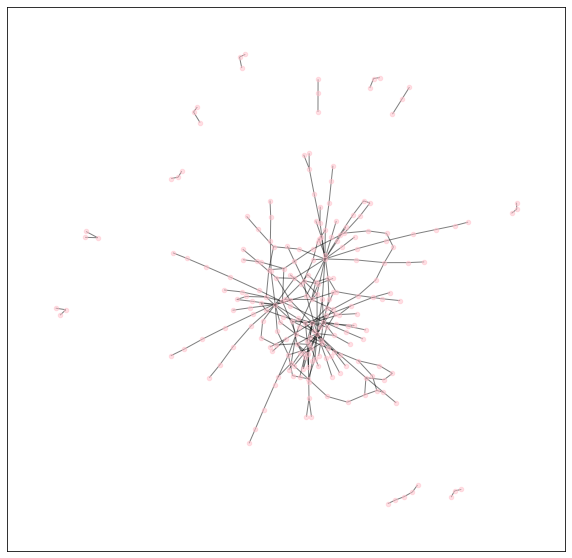

In [ ]:
# Изобразим клики
clique_bipartite = nx.make_clique_bipartite(G)
plt.figure(figsize = (10, 10))
nx.draw_networkx(clique_bipartite, with_labels = False, node_color = 'pink', edge_color = 'black', node_size = 20, alpha = 0.5)

### Сообщества

Изучим все сообщества сети связей на основе модульности. 

In [ ]:
# Выделим сообщества методом greedy_modularity_communities
communities = community.greedy_modularity_communities(G)
list(communities)


[frozenset({'Anne Conway Viscountess Conway and Killultagh',
            'David Lloyd',
            'Edward Haistwell',
            'George Keith',
            'Isaac Norris',
            'Isabel Yeamans',
            'James Logan',
            'Jane Sowle',
            'John Bartram',
            'Joseph Besse',
            'Peter Collinson',
            'Richard Claridge',
            'Samuel Bownas',
            'Tace Sowle',
            'Thomas Story',
            'William Bradford',
            'William Penn'}),
 frozenset({'Anthony Pearson',
            'Dorcas Erbery',
            'Elizabeth Leavens',
            'Francis Howgill',
            'George Fox the younger',
            'Gervase Benson',
            'Hannah Stranger',
            'James Nayler',
            'Margaret Fell',
            'Martha Simmonds',
            'Richard Farnworth',
            'Robert Rich',
            'Thomas Aldam',
            'Thomas Holme',
            'Thomas Lower',
            'William G

In [ ]:
# Количество полученных сообществ
len(communities)

18

Сформируем классы на основе значений центральности по собственному вектору.


In [ ]:
modularity_dict = {}
for i, c in enumerate(communities):
  for name in c:
    modularity_dict[name] = i
nx.set_node_attributes(G, modularity_dict, 'modularity')

In [ ]:
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]
print('Количество квакеров в классе 0', len(class0))
class0_eigenvector = {n:G.nodes[n]['eigenvector_centrality_coeff'] for n in class0}
class0_eigenvector_sort = sorted(class0_eigenvector.items(), key = itemgetter(1), reverse = True)
print('Модульность класса 0, отсортированная по значению центральности по собственному вектору:')
for node in class0_eigenvector_sort:
  print(node[0], 'Центральность по собственному вектору равна', node[1])

Количество квакеров в классе 0 17
Модульность класса 0, отсортированная по значению центральности по собственному вектору:
William Penn Центральность по собственному вектору равна 0.2703220115399868
George Keith Центральность по собственному вектору равна 0.18384690867915346
William Bradford Центральность по собственному вектору равна 0.06812170326615952
Tace Sowle Центральность по собственному вектору равна 0.04688085927497435
James Logan Центральность по собственному вектору равна 0.04447446026748654
David Lloyd Центральность по собственному вектору равна 0.04279916936862533
Richard Claridge Центральность по собственному вектору равна 0.037457842267371755
Isabel Yeamans Центральность по собственному вектору равна 0.036752364236589646
Isaac Norris Центральность по собственному вектору равна 0.036752364236589646
Edward Haistwell Центральность по собственному вектору равна 0.036752364236589646
Thomas Story Центральность по собственному вектору равна 0.036752364236589646
Anne Conway Visc

In [ ]:
class1 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 1]
print('Количество квакеров в классе 1', len(class1))
class1_eigenvector = {n:G.nodes[n]['eigenvector_centrality_coeff'] for n in class1}
class1_eigenvector_sort = sorted(class1_eigenvector.items(), key = itemgetter(1), reverse = True)
print('Модульность класса 1, отсортированная по значению центральности по собственному вектору:')
for node in class1_eigenvector_sort:
  print(node[0], 'Центральность по собственному вектору равна', node[1])

Количество квакеров в классе 1 17
Модульность класса 1, отсортированная по значению центральности по собственному вектору:
James Nayler Центральность по собственному вектору равна 0.33529741004478675
Margaret Fell Центральность по собственному вектору равна 0.253170949905681
Francis Howgill Центральность по собственному вектору равна 0.19095393782681044
Richard Farnworth Центральность по собственному вектору равна 0.15368535029296415
Anthony Pearson Центральность по собственному вектору равна 0.11120476725256782
Martha Simmonds Центральность по собственному вектору равна 0.07920519864438023
Gervase Benson Центральность по собственному вектору равна 0.06070231190047901
Hannah Stranger Центральность по собственному вектору равна 0.05635184926227045
Robert Rich Центральность по собственному вектору равна 0.052756141766563604
William Tomlinson Центральность по собственному вектору равна 0.052756141766563604
Dorcas Erbery Центральность по собственному вектору равна 0.0455839862351594
Elizab

In [ ]:
class2 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 2]
print('Количество квакеров в классе 2', len(class2))
class2_eigenvector = {n:G.nodes[n]['eigenvector_centrality_coeff'] for n in class2}
class2_eigenvector_sort = sorted(class2_eigenvector.items(), key = itemgetter(1), reverse = True)
print('Модульность класса 2, отсортированная по значению центральности по собственному вектору:')
for node in class2_eigenvector_sort:
  print(node[0], 'Центральность по собственному вектору равна', node[1])

Количество квакеров в классе 2 15
Модульность класса 2, отсортированная по значению центральности по собственному вектору:
George Fox Центральность по собственному вектору равна 0.4491750710859923
Edward Burrough Центральность по собственному вектору равна 0.23147427604862295
John Perrot Центральность по собственному вектору равна 0.18496928077956107
John Crook Центральность по собственному вектору равна 0.13271581268807786
William Dewsbury Центральность по собственному вектору равна 0.11057869321157117
William Mead Центральность по собственному вектору равна 0.09548628544138768
Thomas Salthouse Центральность по собственному вектору равна 0.09548628544138768
William Mucklow Центральность по собственному вектору равна 0.06106681323567699
Ellis Hookes Центральность по собственному вектору равна 0.06106681323567699
Elizabeth Hooten Центральность по собственному вектору равна 0.06106681323567699
William Coddington Центральность по собственному вектору равна 0.06106681323567699
Leonard Fell

In [ ]:
for i,c in enumerate(communities):
    if len(c)>2:
        print('Количество членов в классе ' +str(i)+ ':', len(c))
        print('Перечень лиц в классе ' +str(i)+ ':', list(c))
        print()

Количество членов в классе 0: 17
Перечень лиц в классе 0: ['David Lloyd', 'Jane Sowle', 'Anne Conway Viscountess Conway and Killultagh', 'Thomas Story', 'William Penn', 'Richard Claridge', 'Samuel Bownas', 'Peter Collinson', 'Edward Haistwell', 'Tace Sowle', 'William Bradford', 'James Logan', 'Isabel Yeamans', 'John Bartram', 'Joseph Besse', 'Isaac Norris', 'George Keith']

Количество членов в классе 1: 17
Перечень лиц в классе 1: ['Thomas Lower', 'Dorcas Erbery', 'Richard Farnworth', 'Gervase Benson', 'William Tomlinson', 'Hannah Stranger', 'Thomas Holme', 'William Gibson', 'George Fox the younger', 'Anthony Pearson', 'Martha Simmonds', 'Robert Rich', 'Thomas Aldam', 'Francis Howgill', 'Elizabeth Leavens', 'James Nayler', 'Margaret Fell']

Количество членов в классе 2: 15
Перечень лиц в классе 2: ['William Mead', 'Ellis Hookes', 'John Crook', 'William Mucklow', 'Mary Prince', 'William Crouch', 'Leonard Fell', 'William Coddington', 'Mary Fisher', 'John Perrot', 'Thomas Salthouse', 'Edw